### NOTE
** the test['Kt'].max() values after grouping into hourly data is 7279.907547 = this is a outlier. The reason might be having a dw_solar reading with QC=2 value. Still haven't checked that. But the second highest value of 'Kt' parameter in the testset is 672 (which is way lower) **

In [1]:
import numpy as np
import pandas as pd
import datetime
import glob
import os.path
from pandas.compat import StringIO

### NREL Bird Model implementation: for obtaining clear sky GHI

In [2]:
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
%matplotlib inline
sns.set_color_codes()

In [4]:
import pvlib
from pvlib import clearsky, atmosphere
from pvlib.location import Location

In [5]:
drk = Location(36.621,-116.043, 'US/Pacific', 1010.1072, 'Desert Rock')

In [6]:
times2009 = pd.DatetimeIndex(start='2009-01-01', end='2010-01-01', freq='1min',
                        tz=drk.tz)   # 12 months of 2009 - For testing
times2010and2011 = pd.DatetimeIndex(start='2010-01-01', end='2012-01-01', freq='1min',
                        tz=drk.tz)   # 24 months of 2010 and 2011 - For training

In [7]:
cs_2009 = drk.get_clearsky(times2009) 
cs_2010and2011 = drk.get_clearsky(times2010and2011) # ineichen with climatology table by default
#cs_2011 = bvl.get_clearsky(times2011) 

In [8]:
cs_2009.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
cs_2010and2011.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns
#cs_2011.drop(['dni','dhi'],axis=1, inplace=True) #updating the same dataframe by dropping two columns

In [9]:
cs_2009.reset_index(inplace=True)
cs_2010and2011.reset_index(inplace=True)
#cs_2011.reset_index(inplace=True)

In [10]:
cs_2009['index']=cs_2009['index'].apply(lambda x:x.to_datetime())
cs_2009['year'] = cs_2009['index'].apply(lambda x:x.year)
cs_2009['month'] = cs_2009['index'].apply(lambda x:x.month)
cs_2009['day'] = cs_2009['index'].apply(lambda x:x.day)
cs_2009['hour'] = cs_2009['index'].apply(lambda x:x.hour)
cs_2009['min'] = cs_2009['index'].apply(lambda x:x.minute)

In [11]:
cs_2010and2011['index']=cs_2010and2011['index'].apply(lambda x:x.to_datetime())
cs_2010and2011['year'] = cs_2010and2011['index'].apply(lambda x:x.year)
cs_2010and2011['month'] = cs_2010and2011['index'].apply(lambda x:x.month)
cs_2010and2011['day'] = cs_2010and2011['index'].apply(lambda x:x.day)
cs_2010and2011['hour'] = cs_2010and2011['index'].apply(lambda x:x.hour)
cs_2010and2011['min'] = cs_2010and2011['index'].apply(lambda x:x.minute)

In [12]:
print(cs_2009.shape)
print(cs_2010and2011.shape)
#print(cs_2011.shape)

(525601, 7)
(1051201, 7)


In [13]:
cs_2009.drop(cs_2009.index[-1], inplace=True)
cs_2010and2011.drop(cs_2010and2011.index[-1], inplace=True)
#cs_2011.drop(cs_2011.index[-1], inplace=True)

In [14]:
print(cs_2009.shape)
print(cs_2010and2011.shape)
#print(cs_2011.shape)

(525600, 7)
(1051200, 7)


In [15]:
cs_2010and2011.head()

,index,ghi,year,month,day,hour,min
0,2010-01-01 00:00:00-08:00,0.0,2010,1,1,0,0
1,2010-01-01 00:01:00-08:00,0.0,2010,1,1,0,1
2,2010-01-01 00:02:00-08:00,0.0,2010,1,1,0,2
3,2010-01-01 00:03:00-08:00,0.0,2010,1,1,0,3
4,2010-01-01 00:04:00-08:00,0.0,2010,1,1,0,4


### Import files from each year in a separate dataframe


- year            integer	 year, i.e., 1995
- jday            integer	 Julian day (1 through 365 [or 366])
- month           integer	 number of the month (1-12)
- day             integer	 day of the month(1-31)
- hour            integer	 hour of the day (0-23)
- min             integer	 minute of the hour (0-59)
- dt              real	 decimal time (hour.decimalminutes, e.g., 23.5 = 2330)
- zen             real	 solar zenith angle (degrees)
- dw_solar        real	 downwelling global solar (Watts m^-2)
- uw_solar        real	 upwelling global solar (Watts m^-2)
- direct_n        real	 direct-normal solar (Watts m^-2)
- diffuse         real	 downwelling diffuse solar (Watts m^-2)
- dw_ir           real	 downwelling thermal infrared (Watts m^-2)
- dw_casetemp     real	 downwelling IR case temp. (K)
- dw_dometemp     real	 downwelling IR dome temp. (K)
- uw_ir           real	 upwelling thermal infrared (Watts m^-2)
- uw_casetemp     real	 upwelling IR case temp. (K)
- uw_dometemp     real	 upwelling IR dome temp. (K)
- uvb             real	 global UVB (milliWatts m^-2)
- par             real	 photosynthetically active radiation (Watts m^-2)
- netsolar        real	 net solar (dw_solar - uw_solar) (Watts m^-2)
- netir           real	 net infrared (dw_ir - uw_ir) (Watts m^-2)
- totalnet        real	 net radiation (netsolar+netir) (Watts m^-2)
- temp            real	 10-meter air temperature (?C)
- rh              real	 relative humidity (%)
- windspd         real	 wind speed (ms^-1)
- winddir         real	 wind direction (degrees, clockwise from north)
- pressure        real	 station pressure (mb)


In [16]:
cols = ['year', 'jday', 'month', 'day','hour','min','dt','zen','dw_solar','dw_solar_QC','uw_solar',
       'uw_solar_QC', 'direct_n','direct_n_QC','diffuse', 'diffuse_QC', 'dw_ir', 'dw_ir_QC', 'dw_casetemp',
       'dw_casetemp_QC', 'dw_dometemp','dw_dometemp_QC','uw_ir', 'uw_ir_QC', 'uw_casetemp','uw_casetemp_QC',
       'uw_dometemp','uw_dometemp_QC','uvb','uvb_QC','par','par_QC','netsolar','netsolar_QC','netir','netir_QC',
       'totalnet','totalnet_QC','temp','temp_QC','rh','rh_QC','windspd','windspd_QC','winddir','winddir_QC',
       'pressure','pressure_QC']

In [17]:
path = r'.\\data\\Desert_Rock\\Exp_1_train'
all_files = glob.glob(path + "/*.dat")
all_files.sort()

df_big_train = pd.concat([pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                 index_col=False,header=None, names=cols) for f in all_files],ignore_index=True)
df_big_train.shape

(1047761, 48)

In [18]:
path = r'.\\data\\Desert_Rock\\Exp_1_test'
all_files = glob.glob(path + "/*.dat")
all_files.sort()

df_big_test = pd.concat((pd.read_csv(f, skipinitialspace = True, quotechar = '"',skiprows=(2),delimiter=' ', 
                 index_col=False,header=None, names=cols) for f in all_files),ignore_index=True)
df_big_test.shape

(525542, 48)

In [19]:
df_big_test[df_big_test['dw_solar']==-9999.9].shape

(11338, 48)

### Merging Clear Sky GHI And the big dataframe

In [20]:
df_train = pd.merge(df_big_train, cs_2010and2011, on=['year','month','day','hour','min'])
df_train.shape

(1047761, 50)

In [21]:
df_test = pd.merge(df_big_test, cs_2009, on=['year','month','day','hour','min'])
df_test.shape

(525542, 50)

In [22]:
df_train.drop(['index'],axis=1, inplace=True) #updating the same dataframe by dropping the index columns from clear sky model
df_test.drop(['index'], axis=1, inplace=True)

In [23]:
df_train.shape

(1047761, 49)

### Managing missing values

In [24]:
# Resetting index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [25]:
# Dropping rows with two or more -9999.9 values in columns

In [26]:
# Step1: Get indices of all rows with 2 or more -999
missing_data_indices = np.where((df_train <=-9999.9).apply(sum, axis=1)>=2)[0]
# Step2: Drop those indices
df_train.drop(missing_data_indices, axis=0, inplace=True)
# Checking that the rows are dropped
df_train.shape

(988587, 49)

In [27]:
missing_data_indices_test = np.where((df_test <= -9999.9).apply(sum, axis=1)>=2)[0]
df_test.drop(missing_data_indices_test, axis=0, inplace=True)
df_test.shape

(524158, 49)

In [28]:
# For the rows with only one cell as -9999.9, replacing this cell with the mean of the column

#### First resetting index after dropping rows in the previous part of the code

In [29]:
# 2nd time - Reseting Index
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [30]:
one_miss_train_idx = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]

In [31]:
len(one_miss_train_idx)

16067

In [32]:
df_train.shape

(988587, 49)

In [33]:
col_names = df_train.columns
from collections import defaultdict
stats = defaultdict(int)
total_single_missing_values = 0
for name in col_names:
    col_mean = df_train[~(df_train[name] == -9999.9)][name].mean()
    missing_indices = np.where((df_train[name] == -9999.9))
    stats[name] = len(missing_indices[0])
    df_train[name].loc[missing_indices] = col_mean
    total_single_missing_values += sum(df_train[name] == -9999.9)
    

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [34]:
#df_col_min = df_train.apply(min, axis=0)
#df_col_max = df_train.apply(max, axis =0)
#print(df_col_min, df_col_max)

In [35]:
train = np.where((df_train <=-9999.9).apply(sum, axis=1)==1)[0]

In [36]:
len(train)

0

In [37]:
# doing the same thing on test dataset

In [38]:
one_miss_test_idx = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]
len(one_miss_test_idx)

10590

In [39]:
col_names_test = df_test.columns
from collections import defaultdict
stats_test = defaultdict(int)
total_single_missing_values_test = 0
for name in col_names_test:
    col_mean = df_test[~(df_test[name] == -9999.9)][name].mean()
    missing_indices = np.where((df_test[name] == -9999.9))
    stats_test[name] = len(missing_indices[0])
    df_test[name].loc[missing_indices] = col_mean
    total_single_missing_values_test += sum(df_test[name] == -9999.9)
    

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [40]:
test = np.where((df_test <=-9999.9).apply(sum, axis=1)==1)[0]

In [41]:
len(test)

0

In [42]:
df_train.shape

(988587, 49)

In [43]:
df_test.shape

(524158, 49)

### Exploratory Data Analysis

In [44]:
dw_solar_everyday = df_test.groupby(['jday'])['dw_solar'].mean()
ghi_everyday = df_test.groupby(['jday'])['ghi'].mean()
j_day = df_test['jday'].unique()

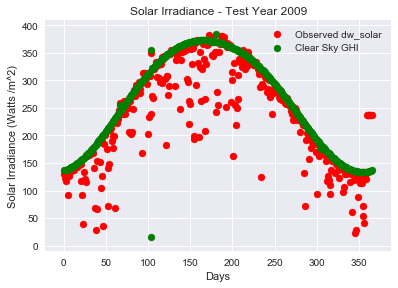

In [45]:
fig = plt.figure()

axes1 = fig.add_axes([0.1,0.1,0.8,0.8])
#axes2 = fig.add_axes([0.1,0.1,0.8,0.8])

axes1.scatter(j_day,dw_solar_everyday,label='Observed dw_solar',color='red')
axes1.scatter(j_day, ghi_everyday, label='Clear Sky GHI',color='green')

axes1.set_xlabel('Days')
axes1.set_ylabel('Solar Irradiance (Watts /m^2)')
axes1.set_title('Solar Irradiance - Test Year 2009')
axes1.legend(loc='best')

fig.savefig('Figure2a.png', bbox_inches = 'tight')

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


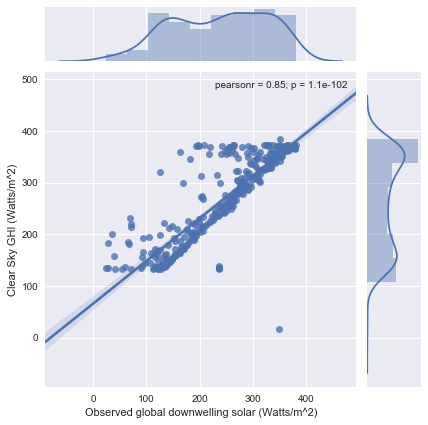

In [46]:
sns.jointplot(x=dw_solar_everyday,y=ghi_everyday,kind='reg')
#plt.title('observed dw_solar vs clear sky ghi')
plt.xlabel('Observed global downwelling solar (Watts/m^2)')
plt.ylabel('Clear Sky GHI (Watts/m^2)')
plt.savefig('Figure3a.png', bbox_inches='tight')

### making the Kt (clear sky index at time t) column by first removing rows with ghi==0

In [47]:
df_train = df_train[df_train['ghi']!=0]
df_test = df_test[df_test['ghi']!=0]
df_train['Kt'] = df_train['dw_solar']/df_train['ghi']
df_test['Kt'] = df_test['dw_solar']/df_test['ghi']

In [48]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [49]:
print("test Kt max: "+str(df_test['Kt'].max()))
print("test Kt min: "+str(df_test['Kt'].min()))
print("test Kt mean: "+str(df_test['Kt'].mean()))
print("\n")
print("train Kt max: "+str(df_train['Kt'].max()))
print("train Kt min: "+str(df_train['Kt'].min()))
print("train Kt mean: "+str(df_train['Kt'].mean()))

test Kt max: 934060.7967236277
test Kt min: -1212.4523861041143
test Kt mean: 6.087694158417696


train Kt max: 36737.73884840597
train Kt min: -404.8538655568123
train Kt mean: 2.4557778502312537


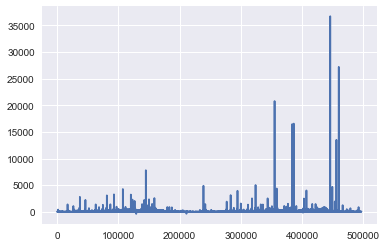

In [50]:
plt.plot(df_train['Kt'])

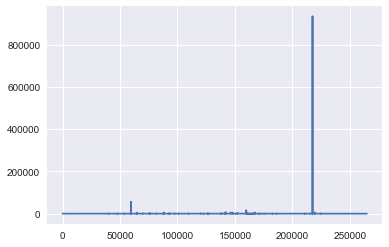

In [51]:
plt.plot(df_test['Kt'])

In [52]:
df_train= df_train[df_train['Kt']< 5000]
df_train= df_train[df_train['Kt']> -1000]
df_test= df_test[df_test['Kt']< 5000]
df_test= df_test[df_test['Kt']> -1000]

#### Group the data (train dataframe)

In [53]:
zen = df_train.groupby(['year','month','day','hour'])['zen'].mean()
dw_solar = df_train.groupby(['year','month','day','hour'])['dw_solar'].mean()
uw_solar = df_train.groupby(['year','month','day','hour'])['uw_solar'].mean()
direct_n = df_train.groupby(['year','month','day','hour'])['direct_n'].mean()
diffuse = df_train.groupby(['year','month','day','hour'])['diffuse'].mean()
dw_ir = df_train.groupby(['year','month','day','hour'])['dw_ir'].mean()
dw_casetemp = df_train.groupby(['year','month','day','hour'])['dw_casetemp'].mean()
dw_dometemp = df_train.groupby(['year','month','day','hour'])['dw_dometemp'].mean()
uw_ir = df_train.groupby(['year','month','day','hour'])['uw_ir'].mean()
uw_casetemp = df_train.groupby(['year','month','day','hour'])['uw_casetemp'].mean()
uw_dometemp = df_train.groupby(['year','month','day','hour'])['uw_dometemp'].mean()
uvb = df_train.groupby(['year','month','day','hour'])['uvb'].mean()
par = df_train.groupby(['year','month','day','hour'])['par'].mean()
netsolar = df_train.groupby(['year','month','day','hour'])['netsolar'].mean()
netir = df_train.groupby(['year','month','day','hour'])['netir'].mean()
totalnet = df_train.groupby(['year','month','day','hour'])['totalnet'].mean()
temp = df_train.groupby(['year','month','day','hour'])['temp'].mean()
rh = df_train.groupby(['year','month','day','hour'])['rh'].mean()
windspd = df_train.groupby(['year','month','day','hour'])['windspd'].mean()
winddir = df_train.groupby(['year','month','day','hour'])['winddir'].mean()
pressure = df_train.groupby(['year','month','day','hour'])['pressure'].mean()
ghi = df_train.groupby(['year','month','day','hour'])['ghi'].mean()
Kt = df_train.groupby(['year','month','day','hour'])['Kt'].mean()

In [54]:
df_new_train = pd.concat([zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,uw_dometemp,
                    uvb,par,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt], axis=1)

In [55]:
df_new_train.head()

zen    dw_solar  uw_solar  direct_n   diffuse  \
year   month day hour                                                         
2010.0 1.0   1.0 6.0   162.750000  229.275124 -1.300000  1.800000 -0.700000   
                 7.0   165.356667  229.275124 -1.366667  1.018333 -0.885000   
                 8.0   163.399000  229.275124 -1.450000  0.781667 -0.781667   
                 9.0   154.172667  229.275124 -1.561667  0.983333 -0.815000   
                 10.0  142.737000  229.275124 -1.428333  1.516667 -0.661667   

                            dw_ir  dw_casetemp  dw_dometemp       uw_ir  \
year   month day hour                                                     
2010.0 1.0   1.0 6.0   243.300000   276.200000   275.700000  308.800000   
                 7.0   241.946667   275.456667   274.983333  307.460000   
                 8.0   244.203333   275.143333   274.721667  304.498333   
                 9.0   245.158333   274.786667   274.335000  303.886667   
                 10.0  256.343333   274.830000   274.453333  305.071667   

                       uw_casetemp    ...      netsolar      netir   totalnet  \
year   month day hour                 ...                                       
2010.0 1.0   1.0 6.0    274.700000    ...           0.0 -65.500000 -65.500000   
                 7.0    274.423333    ...           0.0 -65.521667 -65.521667   
                 8.0    273.966667    ...           0.0 -60.288333 -60.288333   
                 9.0    273.730000    ...           0.0 -58.726667 -58.726667   
                 10.0   273.793333    ...           0.0 -48.730000 -48.730000   

                           temp         rh   windspd     winddir    pressure  \
year   month day hour                                                          
2010.0 1.0   1.0 6.0   3.600000  39.000000  1.000000   56.400000  915.400000   
                 7.0   2.268333  41.808333  2.255000  115.338333  915.410000   
                 8.0   1.918333  43.545000  0.883333  167.170000  915.458333   
                 9.0   2.043333  43.063333  1.690000  130.491667  915.133333   
                 10.0  1.671667  44.681667  1.256667  104.535000  915.161667   

                              ghi         Kt  
year   month day hour                         
2010.0 1.0   1.0 6.0     8.485002  27.021223  
                 7.0    72.956955   4.371045  
                 8.0   234.169751   1.026259  
                 9.0   388.224711   0.596671  
                 10.0  496.624772   0.462711  

[5 rows x 23 columns]

#### Groupdata - test dataframe

In [56]:
test_zen = df_test.groupby(['month','day','hour'])['zen'].mean()
test_dw_solar = df_test.groupby(['month','day','hour'])['dw_solar'].mean()
test_uw_solar = df_test.groupby(['month','day','hour'])['uw_solar'].mean()
test_direct_n = df_test.groupby(['month','day','hour'])['direct_n'].mean()
test_diffuse = df_test.groupby(['month','day','hour'])['diffuse'].mean()
test_dw_ir = df_test.groupby(['month','day','hour'])['dw_ir'].mean()
test_dw_casetemp = df_test.groupby(['month','day','hour'])['dw_casetemp'].mean()
test_dw_dometemp = df_test.groupby(['month','day','hour'])['dw_dometemp'].mean()
test_uw_ir = df_test.groupby(['month','day','hour'])['uw_ir'].mean()
test_uw_casetemp = df_test.groupby(['month','day','hour'])['uw_casetemp'].mean()
test_uw_dometemp = df_test.groupby(['month','day','hour'])['uw_dometemp'].mean()
test_uvb = df_test.groupby(['month','day','hour'])['uvb'].mean()
test_par = df_test.groupby(['month','day','hour'])['par'].mean()
test_netsolar = df_test.groupby(['month','day','hour'])['netsolar'].mean()
test_netir = df_test.groupby(['month','day','hour'])['netir'].mean()
test_totalnet = df_test.groupby(['month','day','hour'])['totalnet'].mean()
test_temp = df_test.groupby(['month','day','hour'])['temp'].mean()
test_rh = df_test.groupby(['month','day','hour'])['rh'].mean()
test_windspd = df_test.groupby(['month','day','hour'])['windspd'].mean()
test_winddir = df_test.groupby(['month','day','hour'])['winddir'].mean()
test_pressure = df_test.groupby(['month','day','hour'])['pressure'].mean()
test_ghi = df_test.groupby(['month','day','hour'])['ghi'].mean()
test_Kt = df_test.groupby(['month','day','hour'])['Kt'].mean()

In [57]:
df_new_test = pd.concat([test_zen,test_dw_solar,test_uw_solar,test_direct_n,test_diffuse,test_dw_ir,
                         test_dw_casetemp,test_dw_dometemp,test_uw_ir,test_uw_casetemp,test_uw_dometemp,
                    test_uvb,test_par,test_netsolar,test_netir,test_totalnet,test_temp,test_rh,
                         test_windspd,test_winddir,test_pressure,test_ghi,test_Kt], axis=1)

In [58]:
df_new_test.loc[2].xs(17,level='day')

,zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,...,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt
hour,,,,,,,,,,,,,,,,,,,,,
6.0,150.286429,-5.457143,4.758099e-17,-0.175000,-0.053571,238.189286,280.017857,279.328571,327.503571,278.535714,...,0.000000,-89.325000,-89.325000,5.610714,61.664286,10.210714,198.364286,895.860714,33.869158,-0.199644
7.0,154.152333,-5.783333,-3.450000e-01,0.123333,-0.021667,238.683333,279.945000,279.300000,327.176667,278.526667,...,0.000000,-88.500000,-88.500000,5.720000,59.485000,9.733333,198.575000,896.445000,156.492998,-0.043188
8.0,154.031833,-5.948333,-2.000000e-01,-0.068333,0.016667,234.365000,279.816667,279.126667,325.691667,278.390000,...,0.000000,-91.336667,-91.336667,5.523333,57.200000,9.743333,206.088333,897.225000,358.157279,-0.016985
9.0,147.761500,-6.048333,-2.966667e-01,0.083333,0.048333,234.465000,279.631667,278.981667,324.173333,278.226667,...,0.000000,-89.698333,-89.698333,5.428333,54.283333,7.906667,204.571667,898.161667,534.190398,-0.011397
10.0,137.994833,-6.270000,-2.583333e-01,0.140000,0.168333,233.670000,279.040000,278.473333,321.188333,277.590000,...,0.000000,-87.516667,-87.516667,4.856667,58.343333,4.830000,221.958333,898.420000,660.519935,-0.009504
11.0,126.708167,-6.398333,-4.233333e-01,0.073333,0.118333,232.613333,278.768333,278.190000,318.916667,277.463333,...,0.000000,-86.303333,-86.303333,4.821667,56.403333,3.730000,242.768333,898.488333,725.681709,-0.008817
12.0,114.824167,-6.381667,-4.466667e-01,0.233333,0.161667,231.091667,277.991667,277.468333,317.415000,276.856667,...,0.000000,-86.321667,-86.321667,4.230000,57.873333,4.493333,240.988333,898.961667,724.381774,-0.008812
13.0,102.804000,-6.466667,-3.716667e-01,0.581667,0.128333,231.006667,277.816667,277.293333,317.900000,276.565000,...,0.000000,-86.886667,-86.886667,3.931667,59.148333,4.121667,251.095000,899.751667,656.728953,-0.009876
14.0,90.783167,4.851667,2.676667e+00,113.013333,7.931667,232.438333,278.385000,277.873333,319.696667,276.965000,...,11.883333,-87.261667,-75.386667,4.480000,54.673333,4.691667,230.323333,900.423333,528.243267,0.011476


### Shifting Kt values to make 1 hour ahead forecast

#### Train dataset

In [59]:
levels_index= []
for m in df_new_train.index.levels:
    levels_index.append(m)

In [60]:
for i in levels_index[0]:
    for j in levels_index[1]:
        df_new_train.loc[i].loc[j]['Kt'] = df_new_train.loc[i].loc[j]['Kt'].shift(-2)

In [61]:
df_new_train = df_new_train[~(df_new_train['Kt'].isnull())]

#### Test dataset

In [62]:
levels_index2= []
for m in df_new_test.index.levels:
    levels_index2.append(m)

In [63]:
for i in levels_index2[0]:
    for j in levels_index2[1]:
        df_new_test.loc[i].loc[j]['Kt'] = df_new_test.loc[i].loc[j]['Kt'].shift(-2)

In [64]:
df_new_test = df_new_test[~(df_new_test['Kt'].isnull())]

In [65]:
df_new_test[df_new_test['Kt']==df_new_test['Kt'].max()]

,,,zen,dw_solar,uw_solar,direct_n,diffuse,dw_ir,dw_casetemp,dw_dometemp,uw_ir,uw_casetemp,...,netsolar,netir,totalnet,temp,rh,windspd,winddir,pressure,ghi,Kt
month,day,hour,,,,,,,,,,,,,,,,,,,,,
7.0,16.0,18.0,23.523667,978.9,196.528333,928.071667,92.3,389.115,315.621667,314.831667,636.071667,312.423333,...,745.785,-246.948333,498.83,36.74,11.503333,5.58,223.173333,903.661667,236.172256,4900.219009


### Normalize train and test dataframe

In [66]:
train_norm = (df_new_train - df_new_train.mean()) / (df_new_train.max() - df_new_train.min())
test_norm =  (df_new_test - df_new_test.mean()) / (df_new_test.max() - df_new_test.min())

In [67]:
train_norm.reset_index(inplace=True,drop=True)
test_norm.reset_index(inplace=True,drop=True)

### Making train and test sets with train_norm and test_norm

#### finding the gcf (greatest common factor) of train and test dataset's length and chop off the extra rows to make it divisible with the batchsize

In [68]:
from fractions import gcd
gcd(train_norm.shape[0],test_norm.shape[0])

C:\Users\s269596\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  


1

In [69]:
import math
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100

In [70]:
train_lim = roundup(train_norm.shape[0])
test_lim = roundup(test_norm.shape[0])

train_random = train_norm.sample(train_lim-train_norm.shape[0])
test_random = test_norm.sample(test_lim-test_norm.shape[0])

train_norm = train_norm.append(train_random)
test_norm = test_norm.append(test_random)

In [71]:
X1 = train_norm.drop('Kt',axis=1)
y1 = train_norm['Kt']

X2 = test_norm.drop('Kt',axis=1)
y2 = test_norm['Kt']

In [72]:
print("X1_train shape is {}".format(X1.shape))
print("y1_train shape is {}".format(y1.shape))
print("X2_test shape is {}".format(X2.shape))
print("y2_test shape is {}".format(y2.shape))

X1_train shape is (9000, 22)
y1_train shape is (9000,)
X2_test shape is (4100, 22)
y2_test shape is (4100,)


In [73]:
X_train = np.array(X1)
y_train  = np.array(y1)
X_test = np.array(X2)
y_test = np.array(y2)

### start of RNN

In [74]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [75]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        #Hidden Dimension
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        #Building the RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initializing the hidden state with zeros
        # (layer_dim, batch_size, hidden_dim)
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
        
        #One time step (the last one perhaps?)
        out, hn = self.rnn(x, h0)
        
        # Indexing hidden state of the last time step
        # out.size() --> ??
        #out[:,-1,:] --> is it going to be 100,100
        out = self.fc(out[:,-1,:])
        # out.size() --> 100,1
        return out
        

In [76]:
# Instantiating Model Class
input_dim = 22
hidden_dim = 15
layer_dim = 1
output_dim = 1
batch_size = 100

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Instantiating Loss Class
criterion = nn.MSELoss()

# Instantiate Optimizer Class
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# converting numpy array to torch tensor
X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)
X_test = torch.from_numpy(X_test)
y_test = torch.from_numpy(y_test)

# initializing lists to store losses over epochs:
train_loss = []
test_loss = []
train_iter = []
test_iter = []

In [77]:
# Training the model
seq_dim = 1

n_iter =0
num_samples = len(X_train)
test_samples = len(X_test)
batch_size = 100
num_epochs = 1000
feat_dim = X_train.shape[1]

X_train = X_train.type(torch.FloatTensor)
y_train = y_train.type(torch.FloatTensor)
X_test = X_test.type(torch.FloatTensor)
y_test = y_test.type(torch.FloatTensor)

for epoch in range(num_epochs):
    for i in range(0, int(num_samples/batch_size -1)):
        
        
        features = Variable(X_train[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
        Kt_value = Variable(y_train[i*batch_size:(i+1)*batch_size])
        
        #print("Kt_value={}".format(Kt_value))
        
        optimizer.zero_grad()
        
        outputs = model(features)
        #print("outputs ={}".format(outputs))
        
        loss = criterion(outputs, Kt_value)
        
        train_loss.append(loss.data[0])
        train_iter.append(n_iter)

        #print("loss = {}".format(loss))
        loss.backward()
        
        optimizer.step()
        
        
            
        if n_iter%100 == 0:
            for i in range(0,int(test_samples/batch_size -1)):
                features = Variable(X_test[i*batch_size:(i+1)*batch_size, :]).view(-1, seq_dim, feat_dim)
                Kt_test = Variable(y_test[i*batch_size:(i+1)*batch_size])
                
                outputs = model(features)
                
                mse = np.sqrt(np.mean((Kt_test.data.numpy() - outputs.data.numpy().squeeze())**2)/num_samples)
                
                test_iter.append(n_iter)
                test_loss.append(mse)
                
            print('Epoch: {} Iteration: {}. Train_MSE: {}. Test_MSE: {}'.format(epoch, n_iter, loss.data[0], mse))
         
        n_iter += 1  

Epoch: 0 Iteration: 0. Train_MSE: 0.003966538701206446. Test_MSE: 0.001130812512768086
Epoch: 1 Iteration: 100. Train_MSE: 0.002632440533488989. Test_MSE: 0.0011062896374338103
Epoch: 2 Iteration: 200. Train_MSE: 0.012723102234303951. Test_MSE: 0.0011101709757851384
Epoch: 3 Iteration: 300. Train_MSE: 0.003712792182341218. Test_MSE: 0.0011198357270318295
Epoch: 4 Iteration: 400. Train_MSE: 0.0024000676348805428. Test_MSE: 0.0010893943320306424
Epoch: 5 Iteration: 500. Train_MSE: 0.002514314604923129. Test_MSE: 0.0010719508496736451
Epoch: 6 Iteration: 600. Train_MSE: 0.006163809448480606. Test_MSE: 0.0010716691248545676
Epoch: 7 Iteration: 700. Train_MSE: 0.0017601093277335167. Test_MSE: 0.0010757650940062926
Epoch: 8 Iteration: 800. Train_MSE: 0.003962681163102388. Test_MSE: 0.0010588174284900536
Epoch: 10 Iteration: 900. Train_MSE: 0.004066580906510353. Test_MSE: 0.0010260814277412865
Epoch: 11 Iteration: 1000. Train_MSE: 0.01847498118877411. Test_MSE: 0.001021231942463986
Epoch: 12 

Epoch: 101 Iteration: 9000. Train_MSE: 0.0007952108862809837. Test_MSE: 0.00046154360469494334
Epoch: 102 Iteration: 9100. Train_MSE: 0.007126305717974901. Test_MSE: 0.00046041190280596603
Epoch: 103 Iteration: 9200. Train_MSE: 0.0014075912768021226. Test_MSE: 0.0004614066513016144
Epoch: 104 Iteration: 9300. Train_MSE: 0.0002789014542941004. Test_MSE: 0.00045244103593228144
Epoch: 105 Iteration: 9400. Train_MSE: 0.0003866464539896697. Test_MSE: 0.00044783807936535824
Epoch: 106 Iteration: 9500. Train_MSE: 0.0013583694817498326. Test_MSE: 0.0004470002001307655
Epoch: 107 Iteration: 9600. Train_MSE: 0.00044139818055555224. Test_MSE: 0.0004470884650380809
Epoch: 108 Iteration: 9700. Train_MSE: 0.000686520419549197. Test_MSE: 0.0004435735783505552
Epoch: 110 Iteration: 9800. Train_MSE: 0.0011657539289444685. Test_MSE: 0.0004337714087126695
Epoch: 111 Iteration: 9900. Train_MSE: 0.014503971673548222. Test_MSE: 0.00043255092107588735
Epoch: 112 Iteration: 10000. Train_MSE: 0.000350936345057

Epoch: 200 Iteration: 17800. Train_MSE: 0.0002607849892228842. Test_MSE: 0.00026934419764444424
Epoch: 201 Iteration: 17900. Train_MSE: 0.0005724147194996476. Test_MSE: 0.0002652864804038045
Epoch: 202 Iteration: 18000. Train_MSE: 0.006324085406959057. Test_MSE: 0.0002648307187990511
Epoch: 203 Iteration: 18100. Train_MSE: 0.0010683316504582763. Test_MSE: 0.00026496441624383434
Epoch: 204 Iteration: 18200. Train_MSE: 0.00020846891857217997. Test_MSE: 0.0002619900830042477
Epoch: 205 Iteration: 18300. Train_MSE: 0.000190054124686867. Test_MSE: 0.000260853587132507
Epoch: 206 Iteration: 18400. Train_MSE: 0.0008739794720895588. Test_MSE: 0.00026035668258452845
Epoch: 207 Iteration: 18500. Train_MSE: 0.0003191361902281642. Test_MSE: 0.00025980711667727074
Epoch: 208 Iteration: 18600. Train_MSE: 0.0003394092491362244. Test_MSE: 0.0002594830995094089
Epoch: 210 Iteration: 18700. Train_MSE: 0.0007930223364382982. Test_MSE: 0.00025559887443540457
Epoch: 211 Iteration: 18800. Train_MSE: 0.01368

Epoch: 296 Iteration: 26400. Train_MSE: 0.00021177236340008676. Test_MSE: 0.00019497601511968697
Epoch: 297 Iteration: 26500. Train_MSE: 0.002930891700088978. Test_MSE: 0.00019416345250606703
Epoch: 298 Iteration: 26600. Train_MSE: 0.00031651940662413836. Test_MSE: 0.00019393142036267273
Epoch: 300 Iteration: 26700. Train_MSE: 0.00022117035405244678. Test_MSE: 0.00019423855958194863
Epoch: 301 Iteration: 26800. Train_MSE: 0.0005091598141007125. Test_MSE: 0.00019237547685382764
Epoch: 302 Iteration: 26900. Train_MSE: 0.00605410523712635. Test_MSE: 0.00019210810211452953
Epoch: 303 Iteration: 27000. Train_MSE: 0.000951599155087024. Test_MSE: 0.00019186961539648185
Epoch: 304 Iteration: 27100. Train_MSE: 0.00021882649161852896. Test_MSE: 0.0001908692628154145
Epoch: 305 Iteration: 27200. Train_MSE: 0.0001497739285696298. Test_MSE: 0.00019075181673786597
Epoch: 306 Iteration: 27300. Train_MSE: 0.0007653554785065353. Test_MSE: 0.00019035568694604176
Epoch: 307 Iteration: 27400. Train_MSE: 0

Epoch: 393 Iteration: 35000. Train_MSE: 0.0008748149848543108. Test_MSE: 0.00016240993155345308
Epoch: 394 Iteration: 35100. Train_MSE: 0.00029713453841395676. Test_MSE: 0.00016198242532778357
Epoch: 395 Iteration: 35200. Train_MSE: 0.00031342078000307083. Test_MSE: 0.00016187744244822882
Epoch: 396 Iteration: 35300. Train_MSE: 0.0001927760022226721. Test_MSE: 0.00016200204340768927
Epoch: 397 Iteration: 35400. Train_MSE: 0.0028411373496055603. Test_MSE: 0.00016134012938424968
Epoch: 398 Iteration: 35500. Train_MSE: 0.0002713009307626635. Test_MSE: 0.0001610305520645409
Epoch: 400 Iteration: 35600. Train_MSE: 0.00021771833417005837. Test_MSE: 0.00016161172552511512
Epoch: 401 Iteration: 35700. Train_MSE: 0.0004798188165295869. Test_MSE: 0.00016062049487017478
Epoch: 402 Iteration: 35800. Train_MSE: 0.00591813400387764. Test_MSE: 0.00016044486498741528
Epoch: 403 Iteration: 35900. Train_MSE: 0.0008936309604905546. Test_MSE: 0.0001601055098485354
Epoch: 404 Iteration: 36000. Train_MSE: 0

Epoch: 489 Iteration: 43600. Train_MSE: 0.00023108496679924428. Test_MSE: 0.00014580271098163012
Epoch: 491 Iteration: 43700. Train_MSE: 0.00017838709754869342. Test_MSE: 0.00014639600101296404
Epoch: 492 Iteration: 43800. Train_MSE: 0.0002614220720715821. Test_MSE: 0.0001457549850429669
Epoch: 493 Iteration: 43900. Train_MSE: 0.0008374911267310381. Test_MSE: 0.00014555291666915266
Epoch: 494 Iteration: 44000. Train_MSE: 0.0002593439712654799. Test_MSE: 0.000145147345596525
Epoch: 495 Iteration: 44100. Train_MSE: 0.00028846494387835264. Test_MSE: 0.00014527358004405252
Epoch: 496 Iteration: 44200. Train_MSE: 0.00018257336341775954. Test_MSE: 0.00014549169021720938
Epoch: 497 Iteration: 44300. Train_MSE: 0.0027634126599878073. Test_MSE: 0.0001449410779426505
Epoch: 498 Iteration: 44400. Train_MSE: 0.00024443314759992063. Test_MSE: 0.00014463629803516628
Epoch: 500 Iteration: 44500. Train_MSE: 0.00021640461636707187. Test_MSE: 0.00014524045927044862
Epoch: 501 Iteration: 44600. Train_MSE

Epoch: 587 Iteration: 52300. Train_MSE: 0.00021170024410821497. Test_MSE: 0.00013650298359135278
Epoch: 588 Iteration: 52400. Train_MSE: 0.007381679955869913. Test_MSE: 0.0001358339427343797
Epoch: 589 Iteration: 52500. Train_MSE: 0.00021302200912032276. Test_MSE: 0.00013571924120278658
Epoch: 591 Iteration: 52600. Train_MSE: 0.00016017738380469382. Test_MSE: 0.00013629450023383284
Epoch: 592 Iteration: 52700. Train_MSE: 0.00025345373433083296. Test_MSE: 0.00013582263407758697
Epoch: 593 Iteration: 52800. Train_MSE: 0.0008129770867526531. Test_MSE: 0.00013565667540282563
Epoch: 594 Iteration: 52900. Train_MSE: 0.00023055102792568505. Test_MSE: 0.00013527509720908306
Epoch: 595 Iteration: 53000. Train_MSE: 0.0002623962936922908. Test_MSE: 0.00013547615665834606
Epoch: 596 Iteration: 53100. Train_MSE: 0.00017570916679687798. Test_MSE: 0.0001357176567095129
Epoch: 597 Iteration: 53200. Train_MSE: 0.0027042017318308353. Test_MSE: 0.00013524371818206686
Epoch: 598 Iteration: 53300. Train_MS

Epoch: 684 Iteration: 60900. Train_MSE: 0.0011315442388877273. Test_MSE: 0.00012935408498903651
Epoch: 685 Iteration: 61000. Train_MSE: 0.0002951260539703071. Test_MSE: 0.00012908934043842106
Epoch: 686 Iteration: 61100. Train_MSE: 0.00013830045645590872. Test_MSE: 0.00012930153207772952
Epoch: 687 Iteration: 61200. Train_MSE: 0.00020305508223827928. Test_MSE: 0.00012954171225231908
Epoch: 688 Iteration: 61300. Train_MSE: 0.007317474577575922. Test_MSE: 0.0001289401596295297
Epoch: 689 Iteration: 61400. Train_MSE: 0.0001988384174183011. Test_MSE: 0.00012884111386347408
Epoch: 691 Iteration: 61500. Train_MSE: 0.00014454772463068366. Test_MSE: 0.000129380912683884
Epoch: 692 Iteration: 61600. Train_MSE: 0.000247789837885648. Test_MSE: 0.00012899812421018382
Epoch: 693 Iteration: 61700. Train_MSE: 0.0007982656825333834. Test_MSE: 0.00012885976720545657
Epoch: 694 Iteration: 61800. Train_MSE: 0.00020741297339554876. Test_MSE: 0.00012849876300194185
Epoch: 695 Iteration: 61900. Train_MSE: 0

Epoch: 780 Iteration: 69500. Train_MSE: 0.000177473557414487. Test_MSE: 0.00012411933042792892
Epoch: 782 Iteration: 69600. Train_MSE: 0.00017600541468709707. Test_MSE: 0.0001244974374891836
Epoch: 783 Iteration: 69700. Train_MSE: 0.0002487109450157732. Test_MSE: 0.00012428711962568923
Epoch: 784 Iteration: 69800. Train_MSE: 0.0011200064327567816. Test_MSE: 0.00012413222630416182
Epoch: 785 Iteration: 69900. Train_MSE: 0.0002697996096685529. Test_MSE: 0.00012388012301466997
Epoch: 786 Iteration: 70000. Train_MSE: 0.0001260978024220094. Test_MSE: 0.0001240966030695732
Epoch: 787 Iteration: 70100. Train_MSE: 0.0001965820847544819. Test_MSE: 0.0001243325915683549
Epoch: 788 Iteration: 70200. Train_MSE: 0.007274756208062172. Test_MSE: 0.0001237795167444915
Epoch: 789 Iteration: 70300. Train_MSE: 0.00018865316815208644. Test_MSE: 0.0001237012275558049
Epoch: 791 Iteration: 70400. Train_MSE: 0.00013112348096910864. Test_MSE: 0.00012420006390668115
Epoch: 792 Iteration: 70500. Train_MSE: 0.00

Epoch: 877 Iteration: 78100. Train_MSE: 0.0001522362290415913. Test_MSE: 0.00012022324383893292
Epoch: 878 Iteration: 78200. Train_MSE: 0.00012716975470539182. Test_MSE: 0.0001203744765917772
Epoch: 879 Iteration: 78300. Train_MSE: 0.0002166532794944942. Test_MSE: 0.00011989455209305914
Epoch: 880 Iteration: 78400. Train_MSE: 0.00016806811618153006. Test_MSE: 0.00011980686877373558
Epoch: 882 Iteration: 78500. Train_MSE: 0.0001599635143065825. Test_MSE: 0.0001201544057230587
Epoch: 883 Iteration: 78600. Train_MSE: 0.00023918590159155428. Test_MSE: 0.0001199668009732392
Epoch: 884 Iteration: 78700. Train_MSE: 0.0011109268525615335. Test_MSE: 0.00011982460083227393
Epoch: 885 Iteration: 78800. Train_MSE: 0.00024822496925480664. Test_MSE: 0.000119581054829152
Epoch: 886 Iteration: 78900. Train_MSE: 0.00011564009037101641. Test_MSE: 0.00011978884388916696
Epoch: 887 Iteration: 79000. Train_MSE: 0.00019138742936775088. Test_MSE: 0.00012001645611100733
Epoch: 888 Iteration: 79100. Train_MSE:

Epoch: 976 Iteration: 86900. Train_MSE: 9.989670797949657e-05. Test_MSE: 0.00011616115776684386
Epoch: 977 Iteration: 87000. Train_MSE: 0.00013850376126356423. Test_MSE: 0.0001164313438387062
Epoch: 978 Iteration: 87100. Train_MSE: 0.00012078772124368697. Test_MSE: 0.00011658268644084124
Epoch: 979 Iteration: 87200. Train_MSE: 0.00022074107255320996. Test_MSE: 0.00011613409901831018
Epoch: 980 Iteration: 87300. Train_MSE: 0.0001603810815140605. Test_MSE: 0.00011606555213883996
Epoch: 982 Iteration: 87400. Train_MSE: 0.00014690456737298518. Test_MSE: 0.0001163876923569648
Epoch: 983 Iteration: 87500. Train_MSE: 0.00023148208856582642. Test_MSE: 0.00011621783715890919
Epoch: 984 Iteration: 87600. Train_MSE: 0.0011029931483790278. Test_MSE: 0.00011608990748897914
Epoch: 985 Iteration: 87700. Train_MSE: 0.00022949225967749953. Test_MSE: 0.00011585665374444463
Epoch: 986 Iteration: 87800. Train_MSE: 0.00010697000834625214. Test_MSE: 0.00011605619030144985
Epoch: 987 Iteration: 87900. Train_

35600


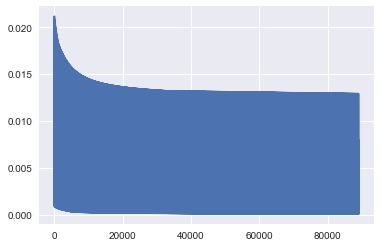

In [78]:
print(len(test_loss))
#plt.plot(test_loss)
plt.plot(train_loss,'-')
#plt.ylim([0.000,0.99])


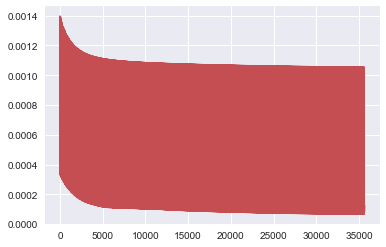

In [79]:
plt.plot(test_loss,'r')

#### Demornamization

In [80]:
rmse = np.sqrt(mse)

In [81]:
rmse_denorm = (rmse * (df_new_test['Kt'].max() - df_new_test['Kt'].min()))+ df_new_test['Kt'].mean()

In [82]:
rmse_denorm

59.72919367089158

In [83]:
df_new_test['Kt'].describe()

count    4071.000000
mean        7.084186
std        81.754144
min        -0.036096
25%        -0.010877
50%        -0.003836
75%         1.108582
max      4900.219009
Name: Kt, dtype: float64

### Saving train and test losses to a csv

In [84]:
df_trainLoss = pd.DataFrame(data={'Train Loss':train_loss,'iteration':train_iter}, columns=['Train Loss','iteration'])
df_trainLoss.to_csv('RNN Paper Results/Exp1_DesertRock_TrainLoss.csv')
df_testLoss = pd.DataFrame(data={'Test Loss':test_loss,'iteration':test_iter}, columns=['Test Loss','iteration'])
df_testLoss.to_csv('RNN Paper Results/Exp1_DesertRock_TestLoss.csv')